# Load Req Lib, Set GPU Config and Load Google Drive

In [ ]:
"""
Created on Sep 28 19:22:13 2022
@author: alighaznavi
"""
import random
import os
import numpy as np
import cv2
import pandas as pd
import glob
import pickle
import tensorflow as tf
import keras
import seaborn as sns
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
from skimage.transform import resize
from skimage import measure, color, io
from IPython.display import display
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, optimizers, models, regularizers, backend
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Input
from tensorflow.keras.utils import plot_model, normalize
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import VGG19
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import Sequential
from warnings import filterwarnings
filterwarnings('ignore')
from focal_loss import SparseCategoricalFocalLoss

!pip install git+https://github.com/artemmavrin/focal-loss.git     #install Focal loss
!git clone https://github.com/umbertogriffo/focal-loss-keras
!pip install dill
!pip install segmentation-models
#import segmentation_models as sm
#import segmentation_models as sm
#sm.set_framework('tf.keras')
#sm.framework()

#Set the GPU for GPU processing 
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

#Load Google Drive
!pwd
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/artemmavrin/focal-loss.git to /tmp/pip-req-build-siq2c4k6
  Running command git clone --filter=blob:none --quiet https://github.com/artemmavrin/focal-loss.git /tmp/pip-req-build-siq2c4k6
  Resolved https://github.com/artemmavrin/focal-loss.git to commit 7a1810a968051b6acfedf2052123eb76ba3128c4
  Preparing metadata (setup.py) ... done
fatal: destination path 'focal-loss-keras' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read Train set 

In [ ]:
train_image_directory = ("/content/drive/MyDrive/Colab Notebooks/data/HeLa Cell Dataset-2022/X_train/train/")

train_mask_directory = ("/content/drive/MyDrive/Colab Notebooks/data/HeLa Cell Dataset-2022/y_train/train/")


# Capture training Images info as a list


In [ ]:
#Read training image as a list
SIZE = 512
#Define Number of classes
n_classes=3 

#Prepare Trainset for training
train_images = []    

images = os.listdir(train_image_directory)
for i, image_name in enumerate(np.sort(images,axis=-1)):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tiff'):
        image = cv2.imread(train_image_directory+image_name, cv2.COLOR_BGR2RGB) #Read Unit8
        image = cv2.resize(image, (SIZE, SIZE)) 
        train_images.append(np.array(image))

#Convert list to array for machine learning processing        
train_images = np.array(train_images)
train_images = cv2.normalize(train_images, None, 0, 255, cv2.NORM_MINMAX)

#Capture training Mask info as a list



In [ ]:
train_masks = []  
masks = os.listdir(train_mask_directory)
for i, image_name in enumerate(np.sort(masks,axis=-1)):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(train_mask_directory+image_name, 0)
        image = cv2.resize(image, (SIZE, SIZE)) 
        train_masks.append(np.array(image))
        
#Convert list to array for machine learning processing        
train_masks = np.array(train_masks)



#Encode labels... but multi dim array so need to flatten, encode and reshape

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


train_masks_encoded_original_shape = train_masks

#Expand dim of masks
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#np.unique(train_masks_encoded_original_shape)

#Categorize the masks 

In [ ]:
from tensorflow.keras.utils import to_categorical

train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))

#Visualize Trainset and Ground trouth

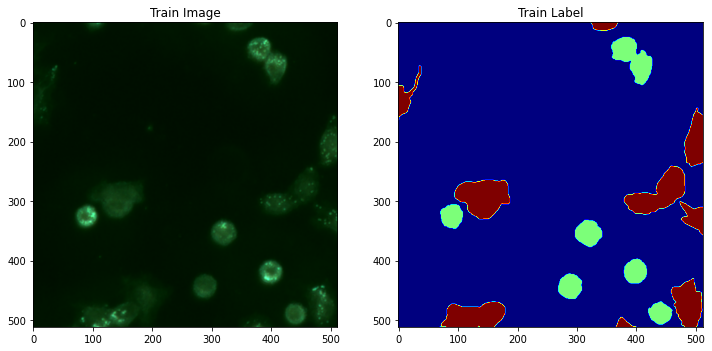

In [ ]:
train_img_number = random.randint(0, len(train_images)-1)
train_img = train_images[train_img_number]
ground_truth= train_masks_input[train_img_number]

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.title('Train Image')
plt.imshow(train_img, cmap='jet')
plt.subplot(1,2,2)
plt.title('Train Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.show()


#Read Validation Set and Data Prepration

In [ ]:
validate_image_directory = ("/content/drive/MyDrive/Colab Notebooks/data/HeLa Cell Dataset-2022/X_validate/validate/")

validate_mask_directory = ("/content/drive/MyDrive/Colab Notebooks/data/HeLa Cell Dataset-2022/y_validate/validate/")


# Read Validation image info as list

In [ ]:
validate_images = []    
images = os.listdir(validate_image_directory)
for i, image_name in enumerate(np.sort(images,axis=-1)):     #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tiff'):
        image = cv2.imread(validate_image_directory+image_name, cv2.COLOR_BGR2RGB) #Read Unit8
        image = cv2.resize(image, (SIZE, SIZE)) 
        validate_images.append(np.array(image))

#Convert list to array for machine learning processing 
validate_images = np.array(validate_images)
validate_images = cv2.normalize(validate_images, None, 0, 255, cv2.NORM_MINMAX)

#Read Val mask as a list

In [ ]:
validate_masks = []  
masks = os.listdir(validate_mask_directory)
for i, image_name in enumerate(np.sort(masks,axis=-1)):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(validate_mask_directory+image_name, 0)
        #image = Image.fromarray(image)
        image = cv2.resize(image, (SIZE, SIZE)) 
        validate_masks.append(np.array(image))
        
#Convert list to array for machine learning processing        
validate_masks = np.array(validate_masks)

#Encode  Validation labels

In [ ]:

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


validate_masks_encoded_original_shape = validate_masks

#give one extra dimention to the masks to be same dimention with images for NN
train_images = np.array(train_images)
validate_masks_input = np.expand_dims(validate_masks_encoded_original_shape, axis=3)

#np.unique(validate_masks_encoded_original_shape)

#Categorize the masks 


In [ ]:
from tensorflow.keras.utils import to_categorical

validate_masks_cat = to_categorical(validate_masks_input, num_classes=n_classes)
y_validate_cat = validate_masks_cat.reshape((validate_masks_input.shape[0], validate_masks_input.shape[1], validate_masks_input.shape[2], n_classes))


#Visualize validation set

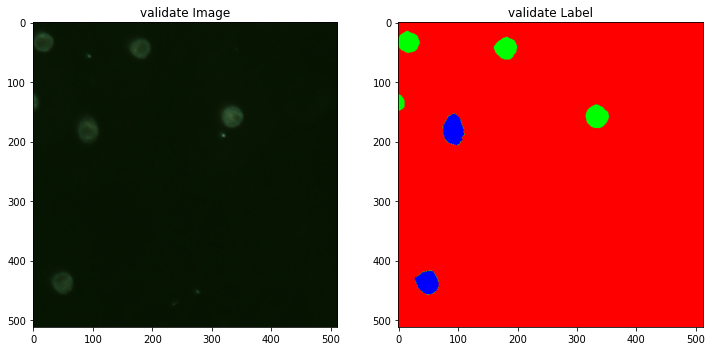

In [ ]:
import random
valid_img_number = random.randint(0, len(validate_images)-1)
valid_img = validate_images[valid_img_number]
vali_ground_truth=y_validate_cat[valid_img_number]


plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.title('validate Image')
plt.imshow(valid_img, cmap='jet')
plt.subplot(1,2,2)
plt.title('validate Label')
plt.imshow(vali_ground_truth[:,:,:], cmap='gray')
plt.show()


#Important parameters and Metrics for training 

In [ ]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]
num_labels = 3 
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8
n_classes=3
activation='softmax'
optim = tf.keras.optimizers.Adam(LR)

In [ ]:
def dice_coeficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coeficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coeficient_loss(y_true, y_pred):
    return -jacard_coeficient(y_true, y_pred)


def dice_coeficient_loss(y_true, y_pred):
    return -dice_coeficient(y_true, y_pred)


# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.75, 0.75])) 
focal_loss2 = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (2 * focal_loss2)

#total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics3= [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), jacard_coeficient,'accuracy']



#Calculate Class Weights

In [ ]:
from sklearn.utils import class_weight
#from sklearn.utils import class_weight
import sklearn

class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(train_masks_reshaped_encoded), y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

class_weights = dict(enumerate(class_weights))
class_weights1 = dict(zip([0,1,2],np.reshape(class_weights,(3,1))))

# CNN Architectures

VGG19+Unet 

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights=None, input_tensor=inputs, pooling=None,
    classes=3, classifier_activation='softmax')

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    #outputs = Conv2D()
    outputs = Conv2D(3, 1, padding="same", activation="softmax")(d4)

    Vgg19_model = Model(inputs, outputs, name="VGG19_U-Net")
    return Vgg19_model
Vgg19_model = build_vgg19_unet((512,512,3))
#Vgg19_model.summary()


In [ ]:
# compling model and callbacks functions
Vgg19_model.compile(optimizer=Adam(lr = 1e-3), loss= focal_loss2, metrics= metrics3)

#callbacks
earlystop = EarlyStopping(monitor = 'val_loss', 
                          #min_delta = 0, 
                          patience = 30,
                          verbose = 1
                          #restore_best_weights = True
                          )

print(Vgg19_model.summary())

start2 = datetime.now()
Vgg19_model_history1 = Vgg19_model.fit(train_images, 
          y_train_cat,
          batch_size = batch_size,
                    validation_data = (validate_images, y_validate_cat),
                    steps_per_epoch= len(train_images)//batch_size, 
                    validation_steps=len(validate_images)//batch_size, 
                    verbose=True,
                    shuffle=False, 
                    epochs=200
                    callbacks=[earlystop]
                    )
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("ResNet execution time is: ", execution_time_Att_Unet)

Vgg19_model.save('/content/drive/MyDrive/Model_Final_Report/'+'VGG19_UNet_model_200epochs_B_categorical_Focal_Loss_relu_Lr-3_Data_Org_Metric3.hdf5')


Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

Inception U-Net Architecture

In [ ]:
from keras.layers import Convolution2D,Activation, BatchNormalization,MaxPooling2D, concatenate
def InceptionModule(inputs, numFilters = 32):
    
    tower_0 = Convolution2D(numFilters, (1,1), padding='same', kernel_initializer = 'he_normal')(inputs)
    tower_0 = BatchNormalization()(tower_0)
    tower_0 = Activation("relu")(tower_0)
    
    tower_1 = Convolution2D(numFilters, (1,1), padding='same',kernel_initializer = 'he_normal')(inputs)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation("relu")(tower_1)
    tower_1 = Convolution2D(numFilters, (3,3), padding='same',kernel_initializer = 'he_normal')(tower_1)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation("relu")(tower_1)
    
    tower_2 = Convolution2D(numFilters, (1,1), padding='same',kernel_initializer = 'he_normal')(inputs)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation("relu")(tower_2)
    tower_2 = Convolution2D(numFilters, (3,3), padding='same',kernel_initializer = 'he_normal')(tower_2)
    tower_2 = Convolution2D(numFilters, (3,3), padding='same',kernel_initializer = 'he_normal')(tower_2)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation("relu")(tower_2)
    
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)
    tower_3 = Convolution2D(numFilters, (1,1), padding='same',kernel_initializer = 'he_normal')(tower_3)
    tower_3 = BatchNormalization()(tower_3)
    tower_3 = Activation("relu")(tower_3)
    
    inception_module = concatenate([tower_0, tower_1, tower_2, tower_3], axis = 3)
    return inception_module


def DilatedInceptionModule(inputs, numFilters = 32): 
    tower_0 = Convolution2D(numFilters, (1,1), padding='same', dilation_rate = (1,1), kernel_initializer = 'he_normal')(inputs)
    tower_0 = BatchNormalization()(tower_0)
    tower_0 = Activation("relu")(tower_0)
    
    tower_1 = Convolution2D(numFilters, (1,1), padding='same', dilation_rate = (2,2), kernel_initializer = 'he_normal')(inputs)
    tower_1 = BatchNormalization()(tower_1)
    tower_1 = Activation("relu")(tower_1)
    
    tower_2 = Convolution2D(numFilters, (1,1), padding='same', dilation_rate = (3,3), kernel_initializer = 'he_normal')(inputs)
    tower_2 = BatchNormalization()(tower_2)
    tower_2 = Activation("relu")(tower_2)
    
    dilated_inception_module = concatenate([tower_0, tower_1, tower_2], axis = 3)
    return dilated_inception_module


inception_module = InceptionModule

#Simple Inception_Unet

In [ ]:
#from tensorflow.keras.models import Model, Input
from keras.layers import Convolution2D, Activation, BatchNormalization,MaxPooling2D, concatenate
from keras.layers.convolutional import UpSampling2D
#from Inception.InceptionModule import InceptionModule

#input_shape = (512,512,3)
#inputs = Input(input_shape)   
def createInceptionUNet(input_shape = (512,512,3), 
                        n_labels = 3, 
                        numFilters = 32, 
                        output_mode="softmax"):
    
    inputs = Input(input_shape)
    
    conv1 = InceptionModule(inputs, numFilters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = InceptionModule(pool1, 2*numFilters)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = InceptionModule(pool2, 4*numFilters)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = InceptionModule(pool3, 8*numFilters)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = InceptionModule(pool4,16*numFilters)

    up6 = UpSampling2D(size=(2,2))(conv5)
    up6 = InceptionModule(up6, 8*numFilters)
    merge6 = concatenate([conv4,up6],axis=3)
    
    up7 = UpSampling2D(size=(2,2))(merge6)
    up7 = InceptionModule(up7, 4*numFilters)
    merge7 = concatenate([conv3,up7],axis=3)
    
    up8 = UpSampling2D(size=(2,2))(merge7)
    up8 = InceptionModule(up8, 2*numFilters)
    merge8 = concatenate([conv2,up8],axis=3)
    
    up9 = UpSampling2D(size=(2,2))(merge8)
    up9 = InceptionModule(up9, numFilters)
    merge9 = concatenate([conv1,up9],axis=3)
    
    conv10 = Convolution2D(n_labels, (1,1),  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv10 = BatchNormalization()(conv10)
    outputs = Activation(output_mode)(conv10)
    
    #model = Model(input = inputs, output = outputs)
    model = Model(inputs, outputs, name="createInceptionUNet")
    
 
    return model

InceptionUNetmodel = createInceptionUNet()
#model.summary()



In [ ]:
# compling model and callbacks functions
InceptionUNetmodel.compile(optimizer=Adam(lr = 1e-3), loss= focal_loss2, metrics= metrics3)



#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1 
                              patience=30
                             )

print(InceptionUNetmodel.summary())


start2 = datetime.now()
InceptionUNetmodelhistory = InceptionUNetmodel.fit(train_images, 
          y_train_cat,
          batch_size= 8,
          steps_per_epoch= len(train_images)//batch_size, 
          validation_steps=len(validate_images)//batch_size,  
          epochs=200,
          verbose=True,
          validation_data=(validate_images, y_validate_cat)
          callbacks=[earlystopping]
          )
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("InceptionUNetmodel_execution time is: ", execution_time_Att_Unet)

InceptionUNetmodel.save('/content/drive/MyDrive/Model_September/'+'InceptionUNetmodel_200epochs_B_categorical_Focal_Loss_relu_Lr-3_Data_Org_Metric3.hdf5')


Model: "createInceptionUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 512, 512, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  128         ['input_1[0][0]']                
                                )                                               

Unet conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)


In [ ]:
def convolutional_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

Repeating Element


In [ ]:
def repeating_element(tensor, rep):
    # lambda function to repeat the elements of a tensor along an axis
    #by a factor of repitation.
    # If tensor has shape (--, 512,512,3), lambda return a tensor with the shape
    # of shape (--, 512,512,6), if specified axis=3 and repitation=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

#Simple U_Net

In [ ]:
def Simple_UNet(input_shape, NUM_CLASSES=3, dropout_rate=0.05, batch_norm=True):
    '''
    UNet, 
    
    '''   
    # required parameters for the network structure
    FILTER_NUM = 64 #  filters number for the first layer
    FILTER_SIZE = 3 # convolutional filter size
    UP_SAMP_SIZE = 2 # upsampling filters size

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # Downsampling 1, convolution + pooling
    conv_128 = convolutional_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # Downsampling 2
    conv_64 = convolutional_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # Downsampling 3
    conv_32 = convolutional_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # Downsampling 4
    conv_16 = convolutional_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # Downsampling 5, convolution only
    conv_8 = convolutional_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers 
    
    # Upsampleling 6
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = convolutional_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampleling 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = convolutional_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampleling 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = convolutional_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampleling 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = convolutional_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # convolutional layers (1*1)
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  

    # Simple_Unet_Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model
simple_unet = Simple_UNet

#Run_Simple_Unet


In [ ]:
'''
Simple UNet
'''
simple_unet_model = Simple_UNet(input_shape)


#Attention_unet_model.compile(optimizer=Adam(lr = 1e-3), loss= 'categorical_crossentropy',
             #metrics=['accuracy', jacard_coeficient, 'Recall', ])

simple_unet_model.compile(optimizer=Adam(lr = 1e-3), loss= focal_loss2, metrics= metrics3)

#Attention_unet_model.compile(optimizer=Adam(lr = 1e-3), loss=SparseCategoricalFocalLoss(gamma=2),
             # metrics=['accuracy', jacard_coeficient])

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 30,
                          verbose = 1,
                          restore_best_weights = True)

print(simple_unet_model.summary())
start2 = datetime.now() 
simple_unet_history = simple_unet_model.fit(train_images, y_train_cat,
                    batch_size = 8,
                    validation_data = (validate_images, y_validate_cat),
                    steps_per_epoch= len(train_images)//batch_size, 
                    validation_steps=len(validate_images)//batch_size, 
                    verbose=True,
                    shuffle=False, epochs=200
                    callbacks=[earlystop]
                    )
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)


simple_unet_model.save('/content/drive/MyDrive/Model_September/'+'second_simple_unet_200epochs_B_categorical_Focal_Loss_relu_Lr-5_Data_Org_Metric3_BS8.hdf5')

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_55 (BatchN  (None, 512, 512, 64  256        ['conv2d_64[0][0]']              
 ormalization)                  )                                                              

#Train ResNet 34

In [ ]:
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(train_images)
X_test1 = preprocess_input1(validate_images)

# define model
ResNet34_UNet = sm.Unet(BACKBONE1, encoder_weights = None, input_shape = (512, 512, 3), classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
ResNet34_UNet.compile(optimizer=Adam(lr = 1e-3), loss= focal_loss2, metrics= metrics3)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          patience = 30,
                          mode='auto',
                          verbose = 1
                          )

print(ResNet34_UNet.summary())

start2 = datetime.now()
ResNet_UNet_history = ResNet34_UNet.fit(X_train1, 
          y_train_cat,
          batch_size = 8,
          steps_per_epoch= len(X_train1)//batch_size, 
          validation_steps=len(X_test1)//batch_size,  
          epochs=200,
          verbose=1,
          validation_data=(X_test1, y_validate_cat)
          callbacks=[earlystop]
          )
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("ResNet execution time is: ", execution_time_Att_Unet)
ResNet34_UNet.save('/content/drive/MyDrive/Model_September/'+'ResNet34_UNet_model_200epochs_B_categorical_Focal_Loss_relu_Lr-3_Data_Org_Metric3.hdf5')


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 512, 512, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, 518, 518, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

#Load and Complie Models and Histories to have predictions

# Load Models History 

In [ ]:
#Vgg19_model_history1 = '/content/drive/MyDrive/Model_Final_Report/VGG19_200EP_LR-3_BS8_OK/'
#Vgg19_model_history1 = np.load(Vgg19_model_history1+'Vgg19_model_history1-3LR_BS8.npy',allow_pickle='TRUE').item()

#InceptionUNetmodelhistory = '/content/drive/MyDrive/Model_Final_Report/Inception_200EP_LE-3_BS4_Ok/'
#InceptionUNetmodelhistory = np.load(InceptionUNetmodelhistory+'InceptionUNetmodelhistory-4LR_BS4.npy',allow_pickle='TRUE').item()

#simple_unet_history = '/content/drive/MyDrive/Model_Final_Report/Simple_Unet_200EP_LE-3_BS8_OK/'
#simple_unet_history = np.load(simple_unet_history+'simple_unet_history-3LR_BS8.npy',allow_pickle='TRUE').item()

RESNET34 = '/content/drive/MyDrive/Model_Final_Report/RESNET34_200Ep_LE-3_Ok/'
RESNET34 = np.load(RESNET34+'ResNet_UNet_historyokok-3LR_BS8.npy',allow_pickle='TRUE').item()


#Load All CNN Models

In [ ]:
#model1 = tf.keras.models.load_model("/content/drive/MyDrive/Model_September/RESNET34_200EP/ResNet34_UNet_model_200epochs_B_categorical_Focal_Loss_relu_Lr-5_Data_Org_Metric3.hdf5", compile=False)
Vgg19_model.load_weights ("/content/drive/MyDrive/Model_Final_Report/VGG19_200EP_LR-3_BS8_OK/VGG19_UNet_model_200epochs_B_categorical_Focal_Loss_relu_Lr-3_Data_Org_Metric3.hdf5")
InceptionUNetmodel.load_weights ("/content/drive/MyDrive/Model_Final_Report/Inception_200EP_LE-3_BS4_Ok/InceptionUNetmodel_200epochs_B_categorical_Focal_Loss_relu_Lr-3_Data_Org_Metric3.hdf5")  
simple_unet_model.load_weights ("/content/drive/MyDrive/Model_Final_Report/Simple_Unet_200EP_LE-3_BS8_OK/second_simple_unet_200epochs_B_categorical_Focal_Loss_relu_Lr-5_Data_Org_Metric3_BS8.hdf5")
ResNet34_UNet.load_weights ("/content/drive/MyDrive/Model_Final_Report/RESNET34_200Ep_LE-3_Ok/ResNet34_UNet_model_200epochs_B_categorical_Focal_Loss_relu_Lr-3_Data_Org_Metric3.hdf5")  

Load U-Net Model

In [ ]:
Attention_unet_model = tf.keras.models.load_model("/content/drive/MyDrive/multi_class_models/Multi_Class_Attention_UNet_120epochs_B_categorical_cross_Leakyrelu_Lr-3.hdf5", compile=False)

#Check history plots, one model at a time

In [ ]:
#history = Vgg19_model_history1
#history = InceptionUNetmodelhistory
#history = simple_unet_history
history = RESNET34


plt.rcParams["figure.figsize"] = (30,15)
loss_train = history['loss']
loss_val = history['val_loss']
epochs = range(1, len(loss_train) + 1)

SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 1.3)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Simple_Unet', format='png',figsize=(8, 4), dpi=250)
plt.show()

In [ ]:
#History1 = Vgg19_model_history1
#History1  = InceptionUNetmodelhistory
#History1  = simple_unet_history
History1 = RESNET34

plt.rcParams["figure.figsize"] = (30,15)
acc = History1['jacard_coeficient']
#acc = history.history['accuracy']
val_acc = History1['val_jacard_coeficient']
#val_acc = history.history['val_accuracy']
SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 1)
plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and Validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.savefig('Simple_Unet_Jaccard', format='png',figsize=(8, 4), dpi=250)
plt.show()

#Prepare test Set for Evaluating Models


#Read Testset /images

In [ ]:
test_image_directory = ("/content/drive/MyDrive/Colab Notebooks/data/HeLa Cell Dataset-2022/X_test/test/")

test_mask_directory = ("/content/drive/MyDrive/Colab Notebooks/data/HeLa Cell Dataset-2022/y_test/test/")


#Capture Testset images

In [ ]:
SIZE = 512
test_images = []    
images = os.listdir(test_image_directory)
for i, image_name in enumerate(np.sort(images,axis=-1)):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tiff'):
        image = cv2.imread(test_image_directory+image_name, cv2.COLOR_BGR2RGB) #Read Unit8
        image = cv2.resize(image, (SIZE, SIZE)) 
        test_images.append(np.array(image))

#Convert list to array for machine learning processing        
test_images = np.array(test_images)
test_images = cv2.normalize(test_images, None, 0, 255, cv2.NORM_MINMAX)


#Capture testset Mask info as a list

In [ ]:
test_masks = []  
masks = os.listdir(test_mask_directory)
for i, image_name in enumerate(np.sort(masks,axis=-1)):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(test_mask_directory+image_name, 0)
        #image = Image.fromarray(image)
        image =  cv2.resize(image,(SIZE, SIZE))
        test_masks.append(np.array(image))
        
#Convert list to array for machine learning processing        
test_masks = np.array(test_masks)

#Encode Testset Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

np.unique(test_masks_encoded_original_shape)


test_masks_encoded_original_shape = test_masks

#give one extra dimention to the masks to be same dimention with images for NN
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

#np.unique(test_masks_encoded_original_shape)

#Categorize the testset masks

In [ ]:
from tensorflow.keras.utils import to_categorical
n_classes = 3
test_masks_cat = to_categorical(test_masks_input, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((test_masks_input.shape[0], test_masks_input.shape[1], test_masks_input.shape[2], n_classes))


#Visualize Test set

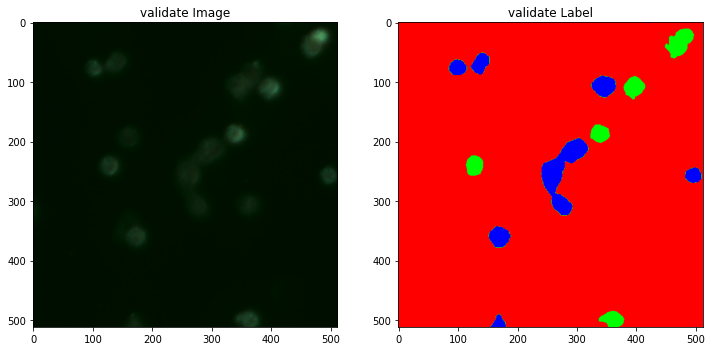

In [ ]:
import random
test_img_number = random.randint(0, len(test_images)-1)
test_img = test_images[test_img_number]
test_ground_truth=y_test_cat[test_img_number]

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.title('validate Image')
plt.imshow(test_img, cmap='jet')
plt.subplot(1,2,2)
plt.title('validate Label')
plt.imshow(test_ground_truth[:,:,:], cmap='gray')
plt.show()

#Evaluate the Models

# Calculate the Prediction of the Model On Test Set

In [ ]:

y_pred_argmax2 = [] 
y_pred2 = []  
for i in range(0,np.shape(test_images)[0]):
  test_images2 = np.reshape(test_images[i],(1,512,512,3))
  #y_pred = InceptionUNetmodel.predict(test_images2)
  #y_pred = simple_unet_model.predict(test_images2)
  y_pred = ResNet34_UNet.predict(test_images2) 
  #y_pred = Vgg19_model.predict(test_images2) 
  y_pred_argmax = np.argmax(y_pred, axis=3)
  y_pred_argmax2.append(np.array(np.reshape(y_pred_argmax,(512,512))))
  y_pred2.append(np.array(np.reshape(y_pred,(512,512,3))))
        
#Convert list to array for machine learning processing        
y_pred2 = np.array(y_pred2)
y_pred_argmax2 = np.array(y_pred_argmax2)
y_pred2.dtype

1/1 [==============================] - 0s 25ms/step


dtype('float32')

#Plot one sample of Prediction

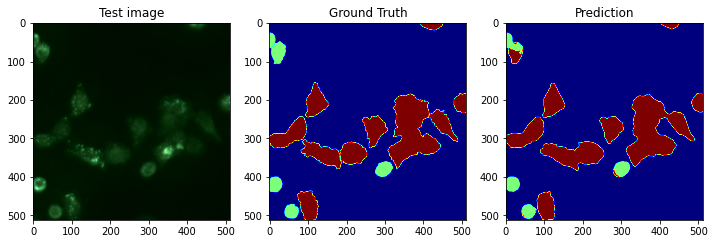

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,3,2)
plt.title('Ground Truth')
plt.imshow(y_test_argmax3, cmap='jet')
plt.subplot(1,3,3)
plt.title('Prediction')
plt.imshow(y_pred_argmax3, cmap='jet')
plt.subplot(1,3,1)
plt.title('Test image')
plt.imshow(test_image3, cmap='gray')
plt.show()

#Visualize segmentation Result

In [ ]:
sample_idx = 15
sample_image = test_images[sample_idx]
test_images_sample = np.reshape(test_images[sample_idx],(1,512,512,3))
y_test_sample = y_test_argmax[sample_idx]
predict_sample = InceptionUNetmodel.predict(test_images_sample)
predict_sample_argmax =  np.reshape(np.argmax(predict_sample, axis=3),(512,512))


1/1 [==============================] - 0s 27ms/step


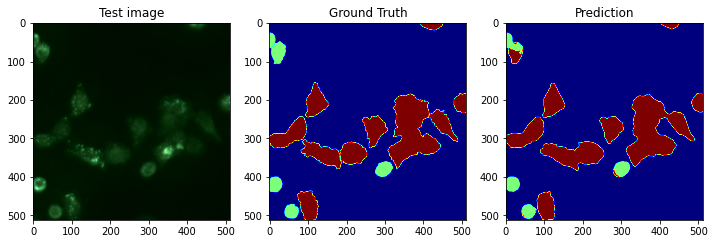

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,3,2)
plt.title('Ground Truth')
plt.imshow(y_test_sample, cmap='jet')
plt.subplot(1,3,3)
plt.title('Prediction')
plt.imshow(y_pred_argmax3, cmap='jet')
plt.subplot(1,3,1)
plt.title('Test image')
plt.imshow(sample_image, cmap='gray')
plt.show()

1/1 [==============================] - 0s 28ms/step


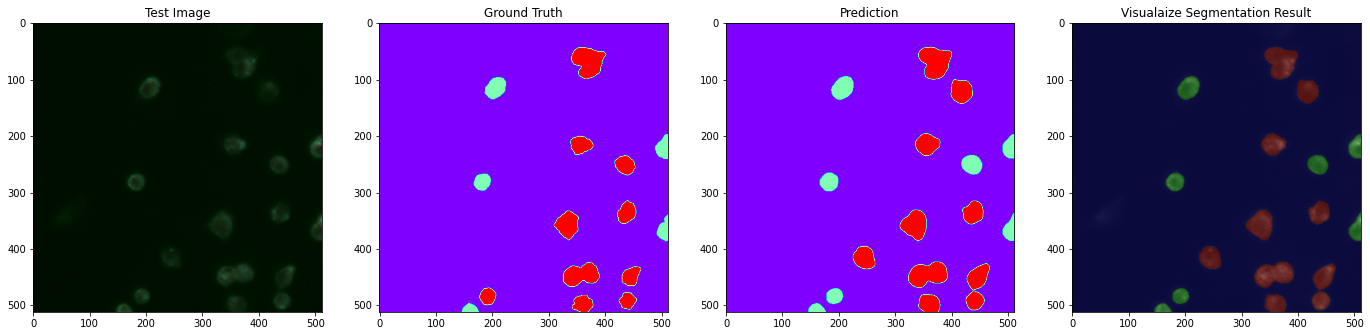

In [ ]:
import random
import cv2
import glob
import os
import math
import numpy as np
import cv2
import pandas as pd
import pandas as pd
from skimage import io, color
import matplotlib.pyplot as plt
sample_idx = 106
sample_image = test_images[sample_idx]
test_images_sample = np.reshape(test_images[sample_idx],(1,512,512,3))
y_test_sample = y_test_argmax[sample_idx]
#predict_sample = InceptionUNetmodel.predict(test_images_sample)
#predict_sample = simple_unet_model.predict(test_images_sample)
#predict_sample = Vgg19_model.predict(test_images_sample)
#predict_sample = InceptionUNetmodel.predict(test_images_sample)
predict_sample = ResNet34_UNet.predict(test_images_sample)
predict_sample_argmax =  np.reshape(np.argmax(predict_sample, axis=3),(512,512))


prediction = predict_sample_argmax
seg_visual = np.zeros((512,512)) # create a matrix of zeroes of same size as image
# Load images as greyscale but make main RGB so we can annotate in colour
seg = predict_sample_argmax
seg_visual[seg == 2] = 3 
seg_visual[seg == 1] = 1   # Change zeroes to label "1" as per your condition(s)
seg_visual[seg == 0] = 2  


#test_img2 = test_img
main_color = sample_image
result = color.label2rgb(seg_visual,main_color,colors=[(0,255,0),(0,0,200),(255,0,0)],alpha=0.001, bg_label=0, bg_color=None)

test_img = sample_image

plt.figure(figsize=(30, 8))
plt.subplot(1,5,1)
plt.title('Test Image')
plt.imshow(test_img, cmap='jet')
plt.subplot(1,5,2)
plt.title('Ground Truth')
plt.imshow(y_test_sample, cmap='rainbow')
plt.subplot(1,5,3) 
plt.title('Prediction')
plt.imshow(prediction, cmap='rainbow')
plt.subplot(1,5,4)
plt.title('Visualaize Segmentation Result')
plt.imshow(result)
plt.show()

#Evaluating the Model Performance With Pre,Rec, Acc, IoU and Mean values

In [ ]:
# Load numpy files
pred = y_pred2
gt = y_test_cat

# pred2 = np.load('y_pred2.npy')
# gt2 = np.load('y_test_cat.npy')

#pred3 = np.load('y_pred2(1).npy')
#gt3 = np.load('y_test_cat(1).npy')
#  Make it True $ Fulse
pred = np.array([ np.argmax(pred, axis=-1)==i for i in range(3) ]).transpose(1,2,3,0)

# gt = gt.astype(int)
# pred = pred.astype(int)

# Make it 0 & 1 (nteger)
gt3 = gt.astype(int)
pred3 = pred.astype(int)
#  Defenitions

def greytobinary(originalImage):
    
    #im_gray = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    im_gray = originalImage
    thresh = 0
    blackAndWhiteImage = cv2.threshold(im_gray, thresh, 1, cv2.THRESH_BINARY)[1]
    # (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
    
    return blackAndWhiteImage

def Metrics_m(Y_pred,Y_val):
    import seaborn as sns
    FP = np.zeros(3)
    FN = np.zeros(3)
    TP = np.zeros(3)
    TN = np.zeros(3)
    cmat = np.zeros((2,2,3))
    
    for i in range (0,3):
        
        FP[i] = len(np.where((Y_pred - Y_val)[:,:,:,i] ==  -1)[i])
        FN[i] = len(np.where((Y_pred - Y_val)[:,:,:,i] ==  1)[i])
        TP[i] = len(np.where((Y_pred + Y_val)[:,:,:,i] ==  2)[i])
        TN[i] = len(np.where((Y_pred + Y_val)[:,:,:,i] ==  0)[i])
        cmat[:,:,i] = [
           [TP[i], FN[i]],
           [FP[i], TN[i]]
        ]
    

    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    Accuracy = (TP+TN)/(TP+FN+TN+FP)
    F1 = 2 * (Precision * Recall)/(Precision + Recall)
    IoU =  TP/(TP+FP+FN)
    DICE = (2 * TP) / (2 * TP+FP+FN)
    
    return cmat,Recall,Precision,Accuracy,F1,IoU, TP, TN, FP, FN,DICE,np.mean(cmat,axis=-1),np.mean(Recall,axis=-1),np.mean(Precision,axis=-1),np.mean(Accuracy,axis=-1),np.mean(F1,axis=-1),np.mean(IoU,axis=-1), np.mean(TP,axis=-1), np.mean(TN,axis=-1), np.mean(FP,axis=-1), np.mean(FN,axis=-1),np.mean(DICE,axis=-1)
#  Call out function
cmat,Recall,Precision,Accuracy,F1,IoU, TP, TN, FP, FN,DICE,cmatm,Recallm,Precisionm,Accuracym,F1m,IoUm, TPm, TNm, FPm, FNm,DICEm = Metrics_m(pred3,gt3)

# Make Pred array to argmax (0,1,2) in Dimention 3:


#weighted_avg_IoU = np.average(IoU, weights= [0.25, 0.75, 0.75])

print(cmat,Recall,Precision,Accuracy,F1,IoU, TP, TN, FP, FN,DICE,cmatm,Recallm,Precisionm,Accuracym,F1m,IoUm, TPm, TNm, FPm, FNm,DICEm,weighted_avg_IoU)

print('\n\nFP =' ,FP)
print('FN =' ,FN)

print('\n\nRecal =' ,Recall)
print('\n\IoU =' ,IoU)
print('Precision =' ,Precision)
print('IoU Average =' ,IoUm)

[[[31966921.   646932.  1000115.]
  [  159747.    96273.   208732.]]

 [[  125386.   192731.   146635.]
  [ 1826666. 33142784. 32723238.]]] [0.99502759 0.87046239 0.82732968] [0.99609296 0.77046625 0.87212993] [0.99163311 0.99151952 0.98957217] [0.99555999 0.8174175  0.84913931] [0.99115923 0.69121393 0.73782979] [31966921.   646932.  1000115.] [ 1826666. 33142784. 32723238.] [125386. 192731. 146635.] [159747.  96273. 208732.] [0.99555999 0.8174175  0.84913931] [[11204656.           154917.33333333]
 [  154917.33333333 22564229.33333333]] 0.8976065522584661 0.8795630455749707 0.9909082657251602 0.8873722638005502 0.8067343164427861 11204656.0 22564229.333333332 154917.33333333334 154917.33333333334 0.8873722638005502 0.7540414840736851


FP = [125386. 192731. 146635.]
FN = [159747.  96273. 208732.]


Recal = [0.99502759 0.87046239 0.82732968]

\IoU = [0.99115923 0.69121393 0.73782979]
Precision = [0.99609296 0.77046625 0.87212993]
IoU Average = 0.8067343164427861


In [ ]:
print('\n IoUm =', IoUm, '\n IoU =', IoU, '\n Recallm =' , Recallm, '\n Precisionm =', Precisionm, '\n Accuracym =', Accuracym, '\n F1m =' , F1m, '\n DICEm =', DICEm, '\n weighted_avg_IoU =', weighted_avg_IoU, '\n TPm =', TPm, '\n TNm =', TNm, '\n FPm =', FPm, '\n FNm =', FNm)


 IoUm = 0.8067343164427861 
 IoU = [0.99115923 0.69121393 0.73782979] 
 Recallm = 0.8976065522584661 
 Precisionm = 0.8795630455749707 
 Accuracym = 0.9909082657251602 
 F1m = 0.8873722638005502 
 DICEm = 0.8873722638005502 
 weighted_avg_IoU = 0.7540414840736851 
 TPm = 11204656.0 
 TNm = 22564229.333333332 
 FPm = 154917.33333333334 
 FNm = 154917.33333333334


#Confusion Matrix

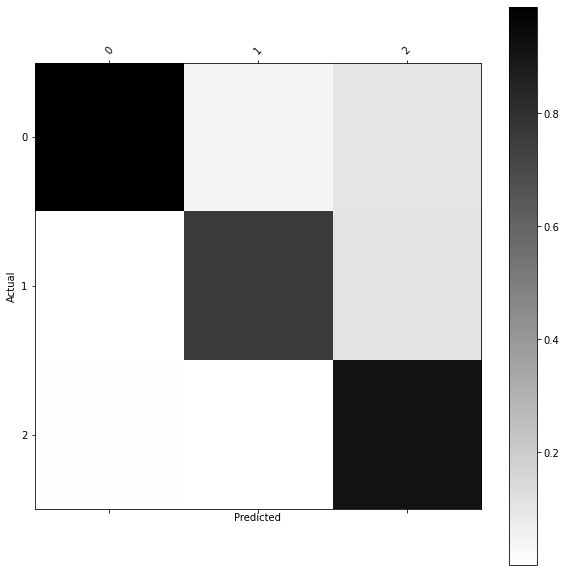

In [ ]:
def cobfusion_plot(y_test_argmax,y_pred_argmax):
  #df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
  import pandas as pd
  import matplotlib.pyplot as plt

  y_actu = pd.Series(np.reshape(y_test_argmax,(512*512)), name='Actual')
  y_pred = pd.Series(np.reshape(y_pred_argmax,(512*512)), name='Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  df_conf_norm = df_confusion / df_confusion.sum(axis=1)
  def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
      plt.matshow(df_confusion, cmap=cmap) # imshow
      #plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(df_confusion.columns))
      plt.xticks(tick_marks, df_confusion.columns, rotation=45)
      plt.yticks(tick_marks, df_confusion.index)
      #plt.tight_layout()
      plt.ylabel(df_confusion.index.name)
      plt.xlabel(df_confusion.columns.name)

  #plot_confusion_matrix(df_confusion)

  plot_confusion_matrix(df_conf_norm)




cobfusion_plot(y_test_argmax[0],y_pred_argmax2[0])




#All Conf Matrix

In [ ]:
for i in range(0,np.shape(y_pred_argmax2)[0]):

  cobfusion_plot(y_test_argmax[i],y_pred_argmax2[i])

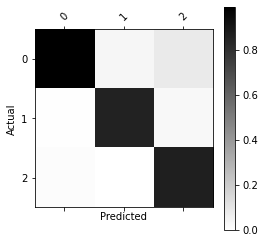

In [ ]:
#df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
import pandas as pd
import matplotlib.pyplot as plt

y_actu = pd.Series(np.reshape(y_test_argmax[0],(512*512)), name='Actual')
y_pred = pd.Series(np.reshape(y_pred_argmax2[0],(512*512)), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

#plot_confusion_matrix(df_confusion)

plot_confusion_matrix(df_conf_norm)

#Calculate the IoU by using Keras Lib

In [ ]:
y_test_argmax = np.argmax(y_test_cat, axis=-1)
y_pred_argmax = np.argmax(y_pred2, axis=-1)

In [ ]:
pred = np.argmax(pred3, axis=-1)
gt = np.argmax(gt3, axis=-1)


# gt = gt.astype(int)
# pred = pred.astype(int)
# Make it 0 & 1 (nteger)

from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(y_test_argmax, y_pred_argmax2)
#IOU_keras.update_state(y_test_cat[:,:,:,0], y_pred_argmax2)
#IOU_keras.update_state(y_test_argmax.astype(int), y_pred_argmax2.astype(int))
IOU_keras.update_state(y_test_argmax, y_pred_argmax)

print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2]  + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] +  values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] +  values[0,2]+ values[1,2])
#class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)
#plt.imshow(train_images[0, :,:,0], cmap='gray')
#plt.imshow(train_masks[0], cmap='gray')


Mean IoU = 0.7978162
[[16777216.    47348.    73559.]
 [   66285.   675229.    76046.]
 [  107688.   112891.   952663.]]
IoU for class1 is:  0.98272735
IoU for class2 is:  0.6905601
IoU for class3 is:  0.72016114


#Visual Bar

In [ ]:
import inspector
from google.colab import output
#I don't know why nbextensions don't work with python3.6 
with output.temporary():
  !pip install --upgrade git+https://github.com/Kreijstal/colab_inspector.git 
  !python2.7 -m pip install --upgrade git+https://github.com/blois/colab_inspector.git #yes, really.
  !jupyter nbextension install --py inspector



# open a scratch cell (Ctrl+Alt+N)
# run there

#Clean GPU Memory

In [ ]:
!pip install numba
from numba import cuda
# all of your code and execution
cuda.select_device(0)
cuda.close()